In [1]:
import numpy as np
from numpy import sin, cos, pi, floor, exp, log, log10, sqrt, cbrt
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose

In [2]:
# load datasets
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=False,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=False,
    transform=ToTensor(),
)

# データローダーの作成 
batch_size = 64 #hyperparameter

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [3]:
# device setting
device = torch.device('mps' if torch.backends.mps.is_available() else "cpu") 
print("Using {} device".format(device))

Using mps device


In [4]:
# model definition
class Autoencoder(nn.Module):
    def __init__(self, dimx=28**2, dimy=512): #hyperparameter
        super(Autoencoder, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(dimx, dimy),
            nn.ReLU(),
            nn.Linear(dimy, dimx),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = Autoencoder().to(device)
print(model)

Autoencoder(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [9]:
type(model) == Autoencoder

True

In [17]:
print("model attributes")
for a in vars(model):
# for a in dir(model):
#     if a in vars(model):
#         continue
#     if callable(getattr(model, a)):
#         continue
    print(a)

print("device:", next(model.parameters()).device)


model attributes
training
_parameters
_buffers
_non_persistent_buffers_set
_backward_pre_hooks
_backward_hooks
_is_full_backward_hook
_forward_hooks
_forward_hooks_with_kwargs
_forward_pre_hooks
_forward_pre_hooks_with_kwargs
_state_dict_hooks
_state_dict_pre_hooks
_load_state_dict_pre_hooks
_load_state_dict_post_hooks
_modules
device: mps:0


In [18]:
learning_rate = 1e-3 #hyperparameter
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

flatten = nn.Flatten()

In [19]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, _) in enumerate(dataloader):
        # print(nn.Flatten(X))

        X = X.to(device)
        
        # 損失誤差を計算
        pred = model(X)
        loss = loss_fn(pred, flatten(X))
        
        # バックプロパゲーション
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [20]:
def test(dataloader, model): # for classification
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, _ in dataloader:
            X = X.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, flatten(X)).item()
            # correct += (pred.argmax(1) == flatten(X)).type(torch.float).sum().item()
    test_loss /= size
    # correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss

Epoch 1
-------------------------------
loss: 0.222360  [    0/60000]
loss: 0.181632  [ 6400/60000]
loss: 0.216077  [12800/60000]
loss: 0.177162  [19200/60000]
loss: 0.220848  [25600/60000]
loss: 0.213720  [32000/60000]
loss: 0.180826  [38400/60000]
loss: 0.191319  [44800/60000]
loss: 0.204512  [51200/60000]
loss: 0.192274  [57600/60000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.003133 

Epoch 2
-------------------------------
loss: 0.202786  [    0/60000]
loss: 0.167101  [ 6400/60000]
loss: 0.198509  [12800/60000]
loss: 0.163517  [19200/60000]
loss: 0.204086  [25600/60000]
loss: 0.197125  [32000/60000]
loss: 0.167578  [38400/60000]
loss: 0.177244  [44800/60000]
loss: 0.189084  [51200/60000]
loss: 0.178333  [57600/60000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.002901 

Epoch 3
-------------------------------
loss: 0.187487  [    0/60000]
loss: 0.155340  [ 6400/60000]
loss: 0.183819  [12800/60000]
loss: 0.151725  [19200/60000]
loss: 0.189245  [25600/60000]
loss: 0.182175  [32000/60000

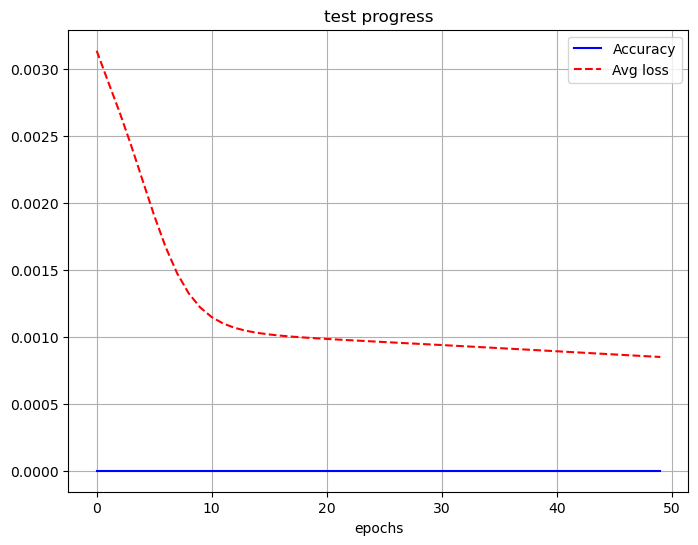

In [21]:
epochs = 50

e = []
c = []
l = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    correct, test_loss = test(test_dataloader, model)
    e.append(t)
    c.append(correct)
    l.append(test_loss)

    
print("Done!")

# グラフを描画
plt.figure(figsize=(8, 6))  # グラフのサイズを調整

plt.plot(e, c, label='Accuracy', linestyle='-', color='blue')
plt.plot(e, l, label='Avg loss', linestyle='--', color='red')

plt.xlabel('epochs')
plt.ylabel('')
plt.title('test progress')
plt.legend()  # 凡例を表示

plt.grid(True)  # グリッドを表示
plt.show()  # グラフを表示

In [22]:
torch.save(model.state_dict(), "AE-D512x100times.pth")
print("saved to model.pth")

saved to model.pth


In [23]:
model = Autoencoder()
model.load_state_dict(torch.load("model0913.pth"))

RuntimeError: Error(s) in loading state_dict for Autoencoder:
	Unexpected key(s) in state_dict: "linear_relu_stack.4.weight", "linear_relu_stack.4.bias". 
	size mismatch for linear_relu_stack.2.weight: copying a param with shape torch.Size([512, 512]) from checkpoint, the shape in current model is torch.Size([784, 512]).
	size mismatch for linear_relu_stack.2.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([784]).

In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[10][0], test_data[10][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Coat", Actual: "Coat"


/Users/kasano/anaconda3/envs/research/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36600 (\N{CJK UNIFIED IDEOGRAPH-8EF8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


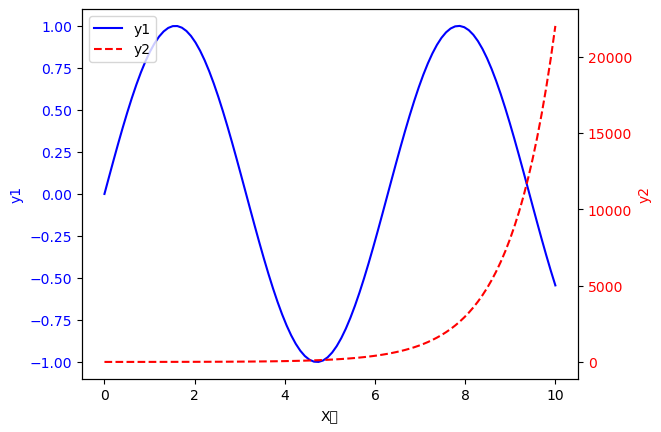

In [22]:
import matplotlib.pyplot as plt
import numpy as np



# サンプルデータ
x = np.linspace(0, 10, 100)

y1 = np.sin(x+np.pi*i)
y2 = np.exp(x+np.pi*i)

# 1つ目のy軸に対するプロット
fig, ax1 = plt.subplots()
ax1.plot(x, y1, 'b-', label='y1')
ax1.set_xlabel('X軸')
ax1.set_ylabel('y1', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# 2つ目のy軸に対するプロット
ax2 = ax1.twinx()
ax2.plot(x, y2, 'r--', label='y2')
ax2.set_ylabel('y2', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# 凡例の表示
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper left')

plt.show()


In [25]:
import torch 
import torch.nn as nn 
 
 
relu = nn.ReLU(inplace=True) 
 
inp = torch.tensor([-1, 0, 1]) 
out = relu(inp) 
 
print(inp) 

tensor([0, 0, 1])


In [2]:
cava = [1,2,2,3,4,5]
print(cava)
print(*[1,2,2,3,4,5])

[1, 2, 2, 3, 4, 5]
1 2 2 3 4 5


In [21]:
layers=[28**2, 512, 512, 10]
flatten = nn.Flatten()

linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])

linear_relu_stack = nn.Sequential(
    *[
        linears[i//2] if (i+1)%2 else nn.ReLU() for i in range((len(layers)-1) * 2)
    ],
    nn.Softmax()
)
print(linear_relu_stack)

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=10, bias=True)
  (5): ReLU()
  (6): Softmax(dim=None)
)
